# Overview

* From planet data over SF Bay
* 2800 80x80 RGB images labeled ship or no-ship
* 700 ships
* 2100 no ships


# Imports

In [149]:
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import json  
import mpl_toolkits
import os
import pickle
import glob
import re
import itertools
from PIL import Image
import time


import sklearn as sklearn
from sklearn.metrics import confusion_matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn import model_selection




import xgboost as xgb
from xgboost import XGBClassifier

# import tensorflow as tf
# import keras
# from keras import backend as K
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
# from keras import initializers, layers, models
# from keras.utils import to_categorical
# from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# from keras import callbacks
# from keras.utils.vis_utils import plot_model
%matplotlib inline



from skimage.feature import hog
from skimage import data, color, exposure
from sklearn import cross_validation

# load images

In [99]:
os.listdir("shipsnet_data/shipsnet");

In [100]:
path =r'/Users/mayamidzik/cv/shipsnet/shipsnet_data/shipsnet'

In [101]:
boats = glob.glob(os.path.join(path,'1*.png'))
no_boats = glob.glob(os.path.join(path,'0*.png'))

In [102]:
len(no_boats)

2100

# Subset boats and create image arrays

In [103]:
boats.extend(no_boats)

In [104]:
image_data = []
image_tag = []

def makeImageDataTagArray(files_list):
    positive = re.compile("/Users/mayamidzik/cv/shipsnet/shipsnet_data/shipsnet/1.*")
    negative = re.compile("/Users/mayamidzik/cv/shipsnet/shipsnet_data/shipsnet/0.*")
    for i in files_list:
        if positive.match(i):
            image_tag.append(1)
        if negative.match(i):
            image_tag.append(0)
        img = Image.open(i)
        arr = np.array(img)
        image_data.append(arr)
        
makeImageDataTagArray(boats)

In [122]:
len(image_tag)

2800

In [106]:
d = {'image': image_data, 'tag': image_tag}
df = pd.DataFrame(data = d)

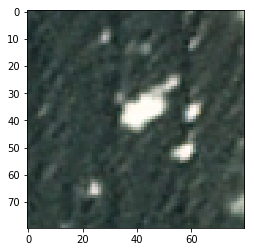

In [128]:
def plotOne(arr):
    plt.subplot(1,1,1)
    plt.imshow(arr)

plotOne(image_data[-20])
    

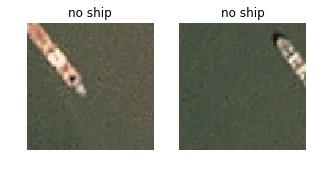

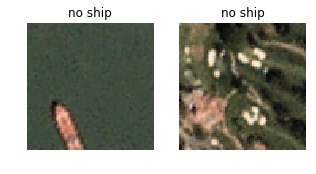

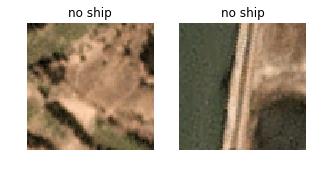

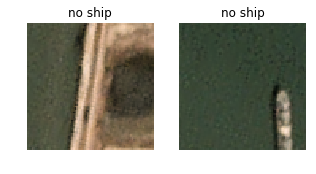

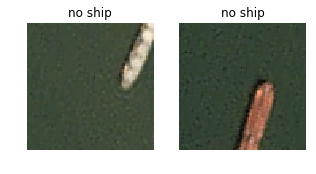

In [257]:
def plotTwo(data,tags): 
    i = 1
    for row in range(5):
        plt.figure(figsize=(5, 15))
        for col in range(2):
            plt.subplot(5,2,i)
            plt.imshow(data[i-1])
            if tags[i-1] == 1:
                plt.title('ship')
            elif tags[i-1] == 0:
                plt.title('no ship')
            plt.axis('off') 
            i+=1
    
plotTwo(image_data[-10:],image_tag[-10:]) 

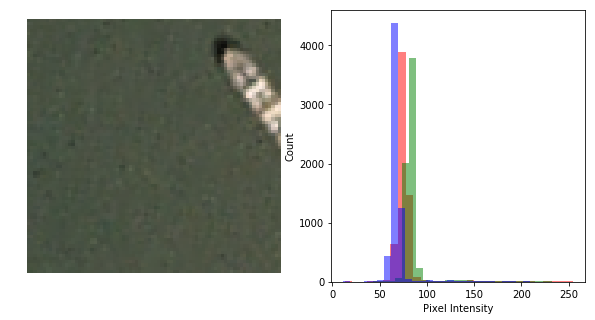

In [131]:
def plotHistogram(a):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);

plotHistogram(image_data[-9])

# Create Transformations of images

## Testing flip and rotate

In [132]:
test = image_data[4]

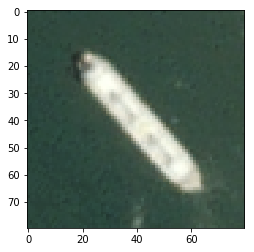

In [133]:
plotOne(test)

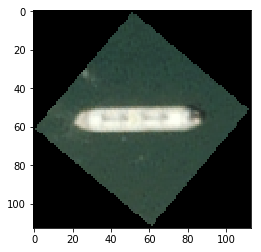

In [134]:
#rotate around the unit circle
from scipy import ndimage

rot = ndimage.interpolation.rotate(test,230, mode = 'constant')
plotOne(rot)

## Run HOG on images

/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


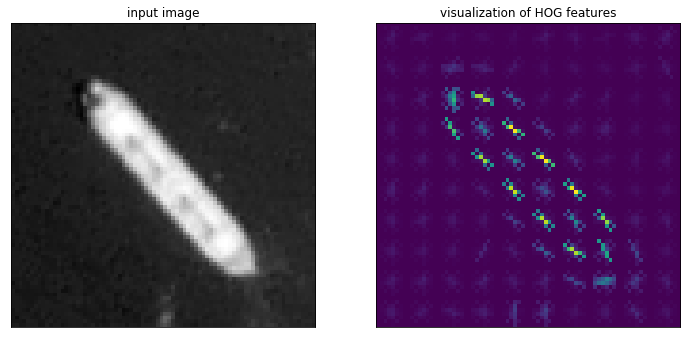

In [135]:
image = color.rgb2gray(test)
hog_vec, hog_vis = hog(image, visualise=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

In [136]:
len(hog_vis)

80

# Test out different models

## Make vectors for modeling & create a test split

In [153]:
def make_vector(image_list):
    vectors = []
    for image in image_list:
        vector = np.ravel(image)
        vectors.append(vector)
    return  (vectors)
    

In [154]:
x_vect = make_vector(image_data)
y_vect = np.ravel(image_tag)

In [203]:
## shuffle both of these vectors
s = np.arange(x_vect.shape[0])
np.random.seed(42)
np.random.shuffle(s)
x_shuf = x_vect[s]
y_shuf = y_vect[s]

In [238]:
xtrain, xtest, ytrain, ytest = train_test_split(x_shuf, y_shuf, test_size=0.2, random_state = 1234)



In [239]:
print(np.max(ytrain), np.min(ytrain), np.mean(ytrain))

1 0 0.24196428571428572


## Test KNN

Training Data Accuracy: 0.98
Test Data Accuracy:     0.92
[[387  15]
 [ 28 130]]


Precision:              0.93
Recall:                 0.96
Specificity:              0.82


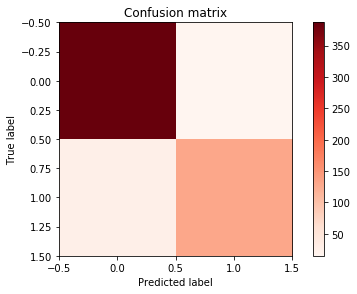

In [240]:
#Rewrite with global so I can access variables

Knn=  KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
clf = Knn.fit(xtrain, ytrain)
train_acc=clf.score(xtrain, ytrain)
test_acc=clf.score(xtest,ytest)
# pickle.dump(clf, open( "model.pkl", "wb" ) )
print("Training Data Accuracy: %0.2f" %(train_acc))
print("Test Data Accuracy:     %0.2f" %(test_acc))

y_true = ytest
y_pred = clf.predict(xtest)


conf = confusion_matrix(y_true, y_pred)
print(conf)

#conf[0, 0] = TP
#conf[1, 0] = FP
#conf[0, 1] = FN
#conf[1, 1] = TN


print ('\n')
print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
print ("Specificity:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[1, 0])))


cm=confusion_matrix(y_true, y_pred, labels=None)

plt.figure()
plot_confusion_matrix(cm)

In [176]:
#seach for the optimal value of K for KNN
k_range = list(range(1, 10))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k,n_jobs=-1)
    scores = cross_val_score(knn, xtrain, ytrain, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)


In [175]:
k_scores
#note that k = 2 seems the highest in this range

[0.9272175599686812,
 0.9432751708306641,
 0.9249715460175102,
 0.9294417841127481,
 0.9187334329845541,
 0.9236421809381451,
 0.9156043935511425,
 0.9169436792654283]

## Test Logistic Regression

Training Data Accuracy: 1.00
Test Data Accuracy:     0.87
[[354  48]
 [ 27 131]]


Precision:              0.93
Recall:                 0.88
Specificity:              0.83
--- 39.76717710494995 seconds ---
--- 39.767269134521484 seconds ---


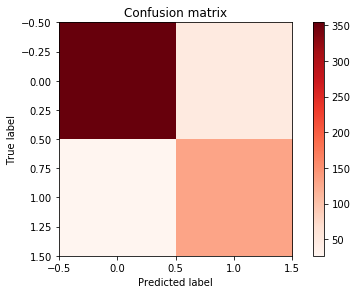

In [255]:
start_time = time.time()

lr = LogisticRegression()
clf = lr.fit(xtrain, ytrain)
train_acc=clf.score(xtrain, ytrain)
test_acc=clf.score(xtest,ytest)
print("Training Data Accuracy: %0.2f" %(train_acc))
print("Test Data Accuracy:     %0.2f" %(test_acc))

y_true = ytest
y_pred = clf.predict(xtest)


conf = confusion_matrix(y_true, y_pred)
print(conf)

print ('\n')
print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
print ("Specificity:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[1, 0])))


cm=confusion_matrix(y_true, y_pred, labels=None)

plt.figure()
plot_confusion_matrix(cm)

print("--- %s seconds ---" % (time.time() - start_time))

print("--- %s seconds ---" % (time.time() - start_time))



## Test SVC

Training Data Accuracy: 1.00
Test Data Accuracy:     0.93
[[375  27]
 [ 15 143]]


Precision:              0.96
Recall:                 0.93
Specificity:              0.91
--- 78.53626871109009 seconds ---


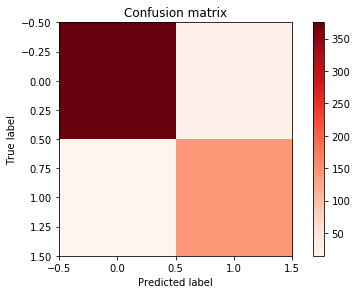

In [253]:
start_time = time.time()

svc = SVC(kernel = 'poly',degree = 3)
clf = svc.fit(xtrain, ytrain)
train_acc=clf.score(xtrain, ytrain)
test_acc=clf.score(xtest,ytest)
print("Training Data Accuracy: %0.2f" %(train_acc))
print("Test Data Accuracy:     %0.2f" %(test_acc))

y_true = ytest
y_pred = clf.predict(xtest)


conf = confusion_matrix(y_true, y_pred)
print(conf)

print ('\n')
print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
print ("Specificity:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[1, 0])))


cm=confusion_matrix(y_true, y_pred, labels=None)

plt.figure()
plot_confusion_matrix(cm)

print("--- %s seconds ---" % (time.time() - start_time))


## Test Decision Tree

Training Data Accuracy: 1.00
Test Data Accuracy:     0.92
[[391  11]
 [ 34 124]]


Precision:              0.92
Recall:                 0.97
Specificity:              0.78
--- 1.6882858276367188 seconds ---


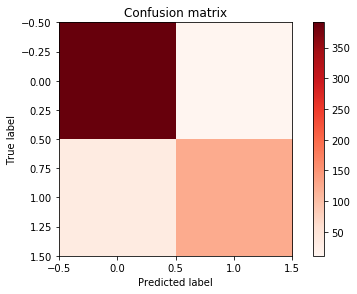

In [262]:
clf = RandomForestClassifier()
clf.fit(xtrain,ytrain)

start_time = time.time()

svc = RandomForestClassifier()
clf = svc.fit(xtrain, ytrain)
train_acc=clf.score(xtrain, ytrain)
test_acc=clf.score(xtest,ytest)
print("Training Data Accuracy: %0.2f" %(train_acc))
print("Test Data Accuracy:     %0.2f" %(test_acc))

y_true = ytest
y_pred = clf.predict(xtest)


conf = confusion_matrix(y_true, y_pred)
print(conf)

print ('\n')
print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
print ("Specificity:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[1, 0])))


cm=confusion_matrix(y_true, y_pred, labels=None)

plt.figure()
plot_confusion_matrix(cm)

print("--- %s seconds ---" % (time.time() - start_time))


## Compare Models

In [276]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier(n_neighbors=2, n_jobs=-1))) 
models.append(('SVC_poly', SVC(kernel = 'poly',degree = 3)))
models.append(('SVC_linear', SVC(kernel='linear')))
models.append(('SVC_rbf', SVC(kernel='rbf', gamma = 0.001)))
models.append(('random_forest', RandomForestClassifier()))

    
    
resultsTrainAccuracy = []
resultsTestAccuracy = []
resultsPrecision = []
resultsRecall = []
resultsSpecificity = []
names = []

for name, model in models:
    print(name)
    names.append(name)
    clf = model.fit(xtrain, ytrain)
    train_acc=clf.score(xtrain, ytrain)
    test_acc=clf.score(xtest,ytest)
    resultsTrainAccuracy.append(train_acc)
    resultsTestAccuracy.append(test_acc)
    y_true = ytest
    y_pred = clf.predict(xtest)

    conf = confusion_matrix(y_true, y_pred)

    Precision = (conf[0, 0] / (conf[0, 0] + conf[1, 0]))
    resultsPrecision.append(Precision)
    Recall = (conf[0, 0] / (conf[0, 0] + conf[0, 1]))
    resultsRecall.append(Recall)
    Specificity = (conf[1, 1] / (conf[1, 1] + conf[1, 0]))
    resultsSpecificity.append(Specificity)


LR
KNN
SVC_poly
SVC_linear
SVC_rbf
random_forest


In [288]:
d = {'model': names, 'train_accuracy': resultsTrainAccuracy, 'test_accuracy':resultsTestAccuracy, 
     'precision' : resultsPrecision, 'recall' : resultsRecall, 'specificity' :resultsSpecificity
    }
models_df = pd.DataFrame(data = d)
models_df

,model,precision,recall,specificity,test_accuracy,train_accuracy
0,LR,0.929134,0.880597,0.829114,0.866071,1.000000
1,KNN,0.932530,0.962687,0.822785,0.923214,0.978571
2,SVC_poly,0.961538,0.932836,0.905063,0.925000,1.000000
3,SVC_linear,0.936548,0.917910,0.841772,0.896429,1.000000
4,SVC_rbf,0.717857,1.000000,0.000000,0.717857,1.000000
5,random_forest,0.916473,0.982587,0.772152,0.923214,0.996875


In [329]:
import seaborn as sns
pd.set_option('display.width', 10000)

s = models_df.style.background_gradient(cmap='coolwarm', low = 3, high =10)
s

,model,precision,recall,specificity,test_accuracy,train_accuracy
0,LR,0.929134,0.880597,0.829114,0.866071,1
1,KNN,0.93253,0.962687,0.822785,0.923214,0.978571
2,SVC_poly,0.961538,0.932836,0.905063,0.925,1
3,SVC_linear,0.936548,0.91791,0.841772,0.896429,1
4,SVC_rbf,0.717857,1,0,0.717857,1
5,random_forest,0.916473,0.982587,0.772152,0.923214,0.996875


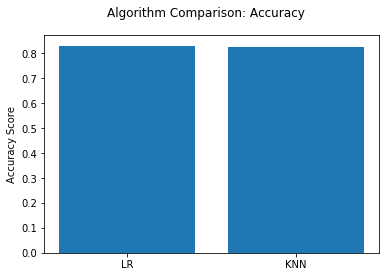

In [274]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison: Accuracy')
ax = fig.add_subplot(111)
plt.bar(names, resultsSpecificity)
ax.set_xticklabels(names)
ax.set_ylabel('Accuracy Score')
plt.show()

In [ ]:

# Generate a confusion matrix plot: 
import pickle 
def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Could be a typical function for classifying:

def train_score(classifier,x,y):
    xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(x, y, test_size=0.2, random_state=1234)
#     ytrain=np.ravel(ytrain)
    clf = classifier.fit(xtrain, ytrain)
    # accuracy for test & train:
    train_acc=clf.score(xtrain, ytrain)
    test_acc=clf.score(xtest,ytest)
    pickle.dump(clf, open( "model.pkl", "wb" ) )
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))
    
    y_true = ytest
    y_pred = clf.predict(xtest)


    conf = confusion_matrix(y_true, y_pred)
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
    print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
    
    cm=confusion_matrix(y_true, y_pred, labels=None)
    
    plt.figure()
    plot_confusion_matrix(cm)

# Practicing sliding windows

In [3]:
# import the necessary packages
from pyimagesearch.helpers import pyramid
from pyimagesearch.helpers import sliding_window
import argparse
import time
import cv2


In [4]:
image = cv2.imread('shipsnet/scenes/lb_1.jpg')

In [5]:
plotOne(image)

NameError: name 'plotOne' is not defined

In [1]:
(winW, winH) = (80, 80)

for resized in pyramid(image, scale=1.5):
    cv.imshow(resized)
#     for (x, y, window) in sliding_window(resized, stepSize=32, windowSize=(winW, winH)):
#         if window.shape[0] != winH or window.shape[1] != winW:
#             continue
#         clone = resized.copy()
#         cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
#         cv2.imshow("Window", clone)
#         cv2.waitKey(1)
#         time.sleep(0.025)
        
        


NameError: name 'pyramid' is not defined